# Segmenting and Clustering Neighborhoods in Toronto

This notebook is made in compliance with the peer-graded assignment for week 3 of IBM's [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone?). The assignment is subdivided into three tasks:
1. **Webscraping.** In this task, we are instructed to webscrape data about the boroughs and neighborhoods in Toronto (see [here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)). Upon inspection, we see that each postal code is assigned *exactly one* borough, but each borough may be assigned *multiple* neighborhoods enclosed in parentheses and separated by a forward slash, and each borough can have multiple postal codes.
2. **Merging.** In this task, we are instructed to provide information about the geogrpahical location of each borough in our webscraped data from the previous task. The information we must provide must include latitude and longitude of the location.
3. **Clustering.** In this task, we are instructed perform clustering on the dataset generated from the second task.

**Note:** Please use [nbviewer](https://nbviewer.jupyter.org/) to see the maps rendered by folium.

## Task 1 - Webscraping

We will first import the necessary libraries for this assignment.

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use(['ggplot'])

import folium
from folium import plugins
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans

We will first download the webpage and save the text of the response as a variable named `html_data`.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data = requests.get(url).text

We will then parse the html data using `BeautifulSoup` and save it as variable named `soup`.

In [3]:
soup = BeautifulSoup(html_data, 'html5lib')

Next, we will create a dataframe to store the data. We will leave it empty for now, and fill it later once we start webscraping.

In [4]:
toronto_data = pd.DataFrame(columns=['Postal Code', 'Borough', 'Neighborhood'])
toronto_data

,Postal Code,Borough,Neighborhood


It is useful to define a helper function, `clean_text`, that will help us clean the text data in each cell. Why is this useful? Take for example the cell in the first row and fifth column. Its text data looks like this:

In [5]:
example_table = soup.find('table')
example_text = example_table.find('tr').find_all('td')[4].text.strip()
example_text

'M5ADowntown Toronto(Regent Park / Harbourfront)'

This is where the helper function comes in handy. First of all, we know that postal codes are stricly *three characters* long. So, we could tell our helper function to take the first three characters and assign it to a variable `postal_code`. For example:

In [6]:
example_postal_code = example_text[:3]
example_postal_code

'M5A'

Next, we know that remain text contains information about the borough and neighborhoods. Knowing that the neighborhoods are enclosed in parentheses, we could split the remaining text on the `(` character and take the first element as our borough. For example:

In [7]:
example_borough = example_text[3:].split('(')[0].strip()
example_borough

'Downtown Toronto'

Lastly, to get the information about the neighborhoods, we simply take the last element after splitting the text on the `(` character, and we remove the `)` character and replace all forward slashes with a comma. For example:

In [8]:
example_neighborhoods = example_text[3:].split('(')[-1].strip(')').replace(' /', ',').strip()
example_neighborhoods

'Regent Park, Harbourfront'

We then create our helper function to do all this repeatedly.

In [9]:
def clean_text(text):
    '''
    Helper function for webscraping. Returns informaion about the
    posal code, borough, and neighborhoods provided in each cell.
    '''
    postal_code = text[:3].strip()
    borough = text[3:].split('(')[0].strip()
    neighborhoods = text[3:].split('(')[-1].strip(')').replace(' /', ',').strip()
    if neighborhoods == 'Not assigned':
        neighborhoods = borough
    return postal_code, borough, neighborhoods

We then begin webscraping.

In [10]:
# If you inspect the Wikipedia page, you will see that the table we will be
# webscraping is the first table, so we could just pass in .find('table'),
# which will return the first table.
table = soup.find('table')

# We then itereate through each row.
for row in table.find_all('tr'):
    
    # For each row, we will iterate through each column.
    for col in row.find_all('td'):
        
        # We extract the text in each cell.
        text = col.text.strip()
        
        # Pass in the text into our helper function.
        postal_code, borough, neighborhoods = clean_text(text)
        
        # Append the dataframe with our extracted information.
        toronto_data = toronto_data.append({
            'Postal Code':postal_code,
            'Borough':borough,
            'Neighborhood':neighborhoods
        }, ignore_index=True)

# We remove all rows with a 'Not assigned' cell.
toronto_data.replace('Not assigned', np.nan, inplace=True)
toronto_data.dropna(axis=0, inplace=True)
toronto_data.reset_index(drop=True, inplace=True)

# Let's see our webscraped data.
toronto_data.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


The shape of our new dataframe is:

In [11]:
print(f'Shape of dataframe: {toronto_data.shape}')

Shape of dataframe: (103, 3)


Therefore, we have 103 records, each with 3 attributes.

## Task 2 - Merging

For this part of the task, we will be extend our above dataframe to include latitude and longitude coordinates for each postal code. Due to complications with the `geocoder` library, we will instead be using the dataset provided, and we will simply merge the two datasets on the `Postal Code` column.

In [12]:
postal_code_lat_lng = pd.read_csv('Geospatial_Coordinates.csv')
postal_code_lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We then merge the two datasets on the `Postal Code` column.

In [13]:
toronto_data = pd.merge(toronto_data, postal_code_lat_lng, how='inner', on='Postal Code')
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


And merging is complete! Let us see whether or not we lost some records during merging.

In [14]:
print(f'Shape of dataframe: {toronto_data.shape}')

Shape of dataframe: (103, 5)


Great! We see that we have not lost any records during merging. This means that we successfully webscraped the correct data.

## Task 3 - Clustering

**Note:** Please use [nbviewer](https://nbviewer.jupyter.org/) to see the maps rendered by folium.

We would first like to see the geographical location of each postal code.

In [15]:
toronto = folium.Map([43.70011, -79.4163], zoom_start=11)

markers = folium.map.FeatureGroup()
# markers = plugins.MarkerCluster()
for lat, lng, pc in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Postal Code']):
    label = folium.Popup(pc, parse_html=True)
    markers.add_child(folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=True
    ))
toronto.add_child(markers)
toronto

We then use [Foursquares's API](https://developer.foursquare.com/) to explore venue recommendations within a specified radius to each postal code geographical location. This will give us an idea of the what places are located in each borough. For this task, we would like to determine the top 100 venues within a 500-meter radius of each postal code location. We first define some helper functions (this were already defined in the assignment notebook, and so it is recommended to review those notebooks for further clarification).

In [16]:
client_id = 'client_id'
client_secret = 'client_secret'
version = '20180605'
limit = 100

def get_category_type(row):
    '''
    Helper function to find the category of each venue.
    '''
    try:
        categories_list = row['categories']
    except KeyError:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, latitude, longitude in zip(names, latitudes, longitudes):
        url = f'https://api.foursquare.com/v2/venues/explore?client_id={client_id}&client_secret={client_secret}&v={version}&limit={limit}&radius={radius}&ll={latitude},{longitude}'
        result = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name, latitude, longitude,
            venue['venue']['name'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories'][0]['name'])
            for venue in result
        ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Postal Code',
        'Postal Code Latitude',
        'Postal Code Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue Category'
    ]
    return nearby_venues

We then run the helper functions to get the top venues.

In [17]:
# toronto_data = toronto_data[toronto_data['Borough'].apply(lambda x: 'Toronto' in x)].reset_index(drop=True)
toronto_venues = get_nearby_venues(toronto_data['Postal Code'], toronto_data['Latitude'], toronto_data['Longitude'], radius=1500)
toronto_venues.head()

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,M3A,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
3,M3A,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
4,M3A,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store


Let's check the size of the resulting dataframe.

In [18]:
print(f'Shape of dataframe: {toronto_venues.shape}')

Shape of dataframe: (6828, 7)


Let's also check how many venues were returned for each postal code.

In [19]:
toronto_venues.groupby('Postal Code').agg({'Venue':'count'}).transpose()

Postal Code,M1B,M1C,M1E,M1G,M1H,M1J,M1K,M1L,M1M,M1N,...,M9A,M9B,M9C,M9L,M9M,M9N,M9P,M9R,M9V,M9W
Venue,30,11,31,33,66,32,35,37,40,14,...,16,21,37,20,19,52,31,39,32,17


Let's also check the number of unique categories returned.

In [20]:
print(toronto_venues['Venue Category'].nunique())

339


We see that there are 339 unique venue categories. At this point, we will perform one-hot encoding on the `Venue Category` column, and then group by the `Postal Code` column to determine the frequency of occurrence of each category in each postal code.

In [21]:
venues_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')
venues_onehot['Postal Code'] = toronto_venues['Postal Code']
venues_onehot = venues_onehot[[venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])]
venues_grouped = venues_onehot.groupby('Postal Code', as_index=False).mean()
venues_grouped.head()

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.033333,0.0,0.000000,0.0,0.333333
1,M1C,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,M1E,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,M1G,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,M1H,0.0,0.0,0.0,0.0,0.015152,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015152,0.000000,0.0,0.015152,0.0,0.000000


Let's check the top 10 venue categories based on their value counts (the number of venues per venue category).We see that there are 272 unique venue categories. 

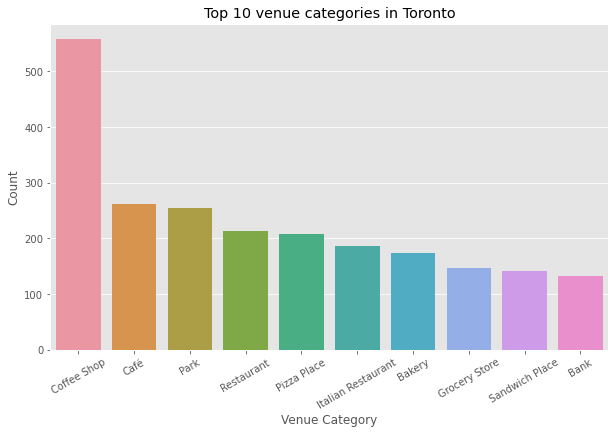

In [22]:
venues_count = venues_onehot.iloc[:, 1:].sum(axis=0).sort_values(ascending=False).to_frame().reset_index()
venues_count.columns = ['Venue Category', 'Count']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.barplot(x='Venue Category', y='Count', data=venues_count.head(10), ax=ax)
ax.set_title('Top 10 venue categories in Toronto')
ax.tick_params(axis='x', rotation=30)

We see that some of the top venue categories in Toronto are food-related, this gives us an idea as to what kind of venue categories our clustering models could base on. Next, we define a helper function that will return the top venue categories based on frequency of occurrence.

In [23]:
def top_venue_categories(row, num_top_venues):
    top_venues = row.iloc[1:]
    top_venues = top_venues.sort_values(ascending=False)
    return top_venues.index.values[:num_top_venues]

We then iterate through each row to determine its top venue categories.

In [24]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Postal Code']
for ind in range(num_top_venues):
    try:
        columns.append(f'{ind+1}{indicators[ind]} Most Common Venue Category')
    except IndexError:
        columns.append(f'{ind+1}th Most Common Venue Category')
        
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Postal Code'] = venues_grouped['Postal Code']

for ind in range(len(venues_grouped)):
    venues_sorted.iloc[ind, 1:] = top_venue_categories(venues_grouped.iloc[ind, :], num_top_venues)
    
venues_sorted.head()

,Postal Code,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,M1B,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Restaurant,Trail,Spa,Gas Station,Supermarket,Caribbean Restaurant,Other Great Outdoors
1,M1C,Park,Italian Restaurant,Gym,Grocery Store,Neighborhood,Hotel,Playground,Gym / Fitness Center,Breakfast Spot,Burger Joint
2,M1E,Pizza Place,Fast Food Restaurant,Bank,Breakfast Spot,Discount Store,Gym / Fitness Center,Shopping Mall,Greek Restaurant,Park,Coffee Shop
3,M1G,Coffee Shop,Pizza Place,Pharmacy,Fast Food Restaurant,Bakery,Sandwich Place,Supermarket,Bus Line,Chinese Restaurant,Gym
4,M1H,Restaurant,Clothing Store,Coffee Shop,Sandwich Place,Bakery,Gas Station,Indian Restaurant,Pharmacy,Sporting Goods Shop,Intersection


We will then fit a K-Means Clustering model, and we specify the value for the number of clusters to be 5.

In [25]:
venues_clustering = venues_grouped.drop('Postal Code', axis=1)
knn = KMeans(n_clusters=5, n_init=20, max_iter=500, random_state=0).fit(venues_clustering)

Let's see what the top 10 most common venue categories are for code postal code, and we would also like to see which cluster it belongs to.

In [26]:
venues_sorted.insert(loc=1, column='Cluster', value=knn.labels_)
venues_sorted.head()

,Postal Code,Cluster,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,M1B,3,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Restaurant,Trail,Spa,Gas Station,Supermarket,Caribbean Restaurant,Other Great Outdoors
1,M1C,4,Park,Italian Restaurant,Gym,Grocery Store,Neighborhood,Hotel,Playground,Gym / Fitness Center,Breakfast Spot,Burger Joint
2,M1E,3,Pizza Place,Fast Food Restaurant,Bank,Breakfast Spot,Discount Store,Gym / Fitness Center,Shopping Mall,Greek Restaurant,Park,Coffee Shop
3,M1G,3,Coffee Shop,Pizza Place,Pharmacy,Fast Food Restaurant,Bakery,Sandwich Place,Supermarket,Bus Line,Chinese Restaurant,Gym
4,M1H,2,Restaurant,Clothing Store,Coffee Shop,Sandwich Place,Bakery,Gas Station,Indian Restaurant,Pharmacy,Sporting Goods Shop,Intersection


We then merge it back with `toronto_data`.

In [27]:
toronto_merged = pd.merge(toronto_data, venues_sorted, how='inner', on='Postal Code')
# toronto_merged['Cluster'].replace(np.nan, -1, inplace=True)
# toronto_merged['Cluster'] = toronto_merged['Cluster'].astype(int)
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,M3A,North York,Parkwoods,43.753259,-79.329656,3,Pharmacy,Coffee Shop,Intersection,Gas Station,Supermarket,Caribbean Restaurant,Liquor Store,Sandwich Place,Bank,Grocery Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Coffee Shop,Middle Eastern Restaurant,Gym,Fast Food Restaurant,Shoe Store,Indian Restaurant,Thrift / Vintage Store,Rental Car Location,Grocery Store,Martial Arts School
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Café,Restaurant,Bakery,Park,Pub,Farmers Market,Thai Restaurant,Italian Restaurant,Diner
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Grocery Store,Dessert Shop,Furniture / Home Store,Sandwich Place,Vietnamese Restaurant,Food Court
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,2,Coffee Shop,Park,Gastropub,Japanese Restaurant,Pizza Place,Hotel,Café,Tea Room,Men's Store,Bubble Tea Shop


Let us now visualize the segmented locations.

In [28]:
toronto = folium.Map([43.70011, -79.4163], zoom_start=11)

colors = plt.cm.viridis(np.linspace(0, 1, toronto_merged['Cluster'].nunique()))
colors = [mpl.colors.rgb2hex(color) for color in colors]

markers = folium.map.FeatureGroup()
for lat, lng, postal_code, borough, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],
    toronto_merged['Postal Code'], toronto_merged['Borough'], toronto_merged['Cluster']):
    label = folium.Popup(f'{borough} ({postal_code})', parse_html=True)
    markers.add_child(folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_opacity=0.6,
        parse_html=True
    ))
    
toronto.add_child(markers)
toronto

Lastly, we would like to examine each cluster separately to draw some insights as to what locations in a cluster have in common based on the tom 10 most common venue categories. During the examination, we will only look into 5 locations per cluster.

In [29]:
toronto_merged.loc[toronto_merged['Cluster'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
2,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Bakery,Park,Pub,Farmers Market,Thai Restaurant,Italian Restaurant,Diner
15,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Bakery,Pizza Place,Farmers Market,Beer Bar,Hotel,Japanese Restaurant,Gastropub
20,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Beer Bar,Farmers Market,Plaza
24,Downtown Toronto,0,Coffee Shop,Café,Pizza Place,Park,Bookstore,Japanese Restaurant,Restaurant,Thai Restaurant,Hotel,Italian Restaurant
25,Downtown Toronto,0,Café,Coffee Shop,Bar,Park,Korean Restaurant,Grocery Store,Italian Restaurant,Bakery,Ice Cream Shop,Indian Restaurant


For Cluster 0, we see that many of its most common venue categories are food-related, including coffee shops, cafes, restaurants, bakeries, ice cream shops, and the like. So we could say that Cluster 0 is composed of locations mostly near restaurants and some other locations like parks and hotels. Let's move on to check Cluster 1.

In [30]:
toronto_merged.loc[toronto_merged['Cluster'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
95,Scarborough,1,Donut Shop,National Park,Farm,Accessories Store,Optical Shop,Pakistani Restaurant,Paintball Field,Outdoors & Recreation,Outdoor Supply Store,Other Great Outdoors


We see that Cluster 1 has only one member in the cluster, and so we conclude that it is distinct from the rest and that no other location is similar to the lone-member of Cluster 1. Let us process to Cluster 2.

In [31]:
toronto_merged.loc[toronto_merged['Cluster'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
1,North York,2,Coffee Shop,Middle Eastern Restaurant,Gym,Fast Food Restaurant,Shoe Store,Indian Restaurant,Thrift / Vintage Store,Rental Car Location,Grocery Store,Martial Arts School
3,North York,2,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Grocery Store,Dessert Shop,Furniture / Home Store,Sandwich Place,Vietnamese Restaurant,Food Court
4,Queen's Park,2,Coffee Shop,Park,Gastropub,Japanese Restaurant,Pizza Place,Hotel,Café,Tea Room,Men's Store,Bubble Tea Shop
7,North York,2,Coffee Shop,Pizza Place,Restaurant,Japanese Restaurant,Bank,Sandwich Place,Burger Joint,Café,Italian Restaurant,Pharmacy
9,Downtown Toronto,2,Coffee Shop,Gastropub,Japanese Restaurant,Italian Restaurant,Steakhouse,Theater,American Restaurant,Café,Cosmetics Shop,Burrito Place


We see a ery similar pattern in Cluster 2 with Cluster 0: that the most common venue categories are mostly food-related. However, we see less occurrences of parks and hotels, which could be what differentiates the two clusters. Another exaplanation for the distinction between both clusters could be that the type of restaurants differ in both clusters. We then proceed to Cluster 3.

In [32]:
toronto_merged.loc[toronto_merged['Cluster'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,North York,3,Pharmacy,Coffee Shop,Intersection,Gas Station,Supermarket,Caribbean Restaurant,Liquor Store,Sandwich Place,Bank,Grocery Store
5,Etobicoke,3,Pharmacy,Bank,Café,Bakery,Liquor Store,Grocery Store,Golf Course,Playground,Shopping Mall,Supermarket
6,Scarborough,3,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Restaurant,Trail,Spa,Gas Station,Supermarket,Caribbean Restaurant,Other Great Outdoors
8,East York,3,Pizza Place,Park,Fast Food Restaurant,Coffee Shop,Athletics & Sports,Pharmacy,Brewery,Soccer Stadium,Skating Rink,Sandwich Place
10,North York,3,Coffee Shop,Grocery Store,Bank,Fast Food Restaurant,Restaurant,Park,Caribbean Restaurant,Pizza Place,Gas Station,Fried Chicken Joint


For Cluster 3, we could say that the clustering model grouped together locations that are close to locations like the bank or the pharmacy. Lastly, we will examine Cluster 4.

In [33]:
toronto_merged.loc[toronto_merged['Cluster'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
11,Etobicoke,4,Park,Sandwich Place,Bank,Pizza Place,Gym,Grocery Store,Farmers Market,Bakery,Coffee Shop,Pharmacy
12,Scarborough,4,Park,Italian Restaurant,Gym,Grocery Store,Neighborhood,Hotel,Playground,Gym / Fitness Center,Breakfast Spot,Burger Joint
17,Etobicoke,4,Baseball Field,Convenience Store,Coffee Shop,Park,Grocery Store,Bank,Pizza Place,Liquor Store,Gym,Fast Food Restaurant
28,North York,4,Park,Pizza Place,Coffee Shop,Bank,Gas Station,Fried Chicken Joint,Baseball Field,Ski Chalet,Sandwich Place,Supermarket
39,North York,4,Bank,Park,Trail,Gas Station,Playground,Shopping Mall,Grocery Store,Skating Rink,Athletics & Sports,Chinese Restaurant


We see that Cluster 4 is composed mainly of parks, playgrounds, and other locations with outdoor activities.